In [10]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [11]:
library(lme4)

In [12]:
library(MuMIn)

In [13]:
library(sjstats)

In [14]:
options(mc.cores = 4)

In [15]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

# Purpose

We discovered a bucketing issue that the sessions in treatment group were not consistantly seeing the new ToC. Some of sessions also saw the old ToC. It happened on all type of viewport sizes. For example on frwiki, in treatment group  more than half of the sessions with larger than 1000px viewport are assigned to old ToC. report

In this notebook, we try to analyze clicks after filtering the clicks on old ToC in treatment group and filtering the clicks on new ToC in control group. 

The caveat: the sessions with 0 click are missing in the analysis data. The analysis is only focus on the sessions which clicked on ToC, whether the sessions with new ToC clicked more than the ones with old ToC. 

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Q1: Is the new table of contents is used more frequently than the previous table of contents


Query clicks per page token by each session

In [32]:
query_click <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t3.year=2022 and t3.month IN (5,6)
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t4.session_dt <= t3.meta.dt
AND event.name IN ( 'ui.toc', 'ui.sidebar-toc')
AND event.action='click' AND event.skinversion=2 
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name, t3.event.editCountBucket, t3.event.pageToken
"

In [33]:
df_clicks_session2 <- wmfdata::query_hive(query_click)

Don't forget to authenticate with Kerberos using kinit



In [34]:
head(df_clicks_session2)

,session_id,wiki,isanon,test_group,name,editcountbucket,pagetoken,clicks
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,00003645f652c5586de5,kowiki,true,treatment,ui.sidebar-toc,0 edits,888ed5c2cf536812553b,2
2,000054a3eb219587e6ed,viwiki,true,control,ui.toc,0 edits,e4aa818062fb8fa00749,1
3,00005658cad1c9bfdd9c,frwiki,true,control,ui.toc,0 edits,6574a7926c6a7559ed51,1
4,0000804a10182a407ca7,ptwiki,true,control,ui.toc,0 edits,5c701e60092b9dbade71,1
5,000082b0ad7fdaf4c466,frwiki,true,control,ui.toc,0 edits,71ebb420d6329e51005b,1
6,000099a312101de4df16,frwiki,true,control,ui.toc,0 edits,b948dcad9283239d243d,1


In [35]:
df <- df_clicks_session2 %>%
  filter(wiki!='foundationwiki') %>%
  filter(!(test_group=='control' & name=='ui.sidebar-toc') & !(test_group=='treatment' & name=='ui.toc')) 


## Logged-in Users

In [71]:
df_loggedin <- df %>% 
  filter(isanon=='false')

### Data exploration
#### Check clicks by edit bucket

In [83]:
df_editbucket <- df_loggedin %>%
    group_by(test_group, editcountbucket) %>%
   summarize(cnt_session_page=n(), cnt_session=n_distinct(session_id),cnt_page=n_distinct(pagetoken), .groups='drop') %>%
   mutate(
     page_per_session = round(cnt_page/cnt_session, 4)
       )
  

In [84]:
df_editbucket 

test_group,editcountbucket,cnt_session_page,cnt_session,cnt_page,page_per_session
<chr>,<chr>,<int>,<int>,<int>,<dbl>
control,0 edits,2130,1622,2130,1.3132
control,1-4 edits,1590,1258,1590,1.2639
control,100-999 edits,2109,1414,2109,1.4915
control,1000+ edits,2925,1797,2925,1.6277
control,5-99 edits,3992,2908,3992,1.3728
treatment,0 edits,418,373,418,1.1206
treatment,1-4 edits,256,228,256,1.1228
treatment,100-999 edits,372,294,372,1.2653
treatment,1000+ edits,493,351,493,1.4046


__Note__ 

Treatment group has lower page per session because some of pages in treatment group were showing old ToC and were exculded from analysis data.

In [85]:
df_editbucket_w <- df_editbucket  %>%
   select(test_group,editcountbucket,cnt_session ) %>%
   spread(test_group, cnt_session)

In [86]:
df_editbucket_w 

editcountbucket,control,treatment
<chr>,<int>,<int>
0 edits,1622,373
1-4 edits,1258,228
100-999 edits,1414,294
1000+ edits,1797,351
5-99 edits,2908,466


In [87]:
sum(df_editbucket_w[, 'control'])

[1] 8999

In [88]:
sum(df_editbucket_w[, 'treatment'])

[1] 1712

In [89]:
df_editbucket_w  <- df_editbucket_w  %>%
  mutate(
    control_pct = round(control*100/8999,2) ,
    treatment_pct = round(treatment*100/1712,2) 
   )

In [90]:
df_editbucket_w

editcountbucket,control,treatment,control_pct,treatment_pct
<chr>,<int>,<int>,<dbl>,<dbl>
0 edits,1622,373,18.02,21.79
1-4 edits,1258,228,13.98,13.32
100-999 edits,1414,294,15.71,17.17
1000+ edits,1797,351,19.97,20.50
5-99 edits,2908,466,32.31,27.22


__Note__  

The proportions of each editcount bucket in treatment group and control group are close . Though control group has a larger portion of `5-99 edits` bucket, and a smaller portion of `0 edits` compared to treatment group, for the entire `<=99 edits` bucket, the proportions are close. 


### Distribution of number of clicks

In [91]:
df_his <- df %>% 
  filter(isanon=='false') %>%
  group_by(test_group, clicks, editcountbucket) %>%
  summarize(cnt=n(), .groups='drop') %>%
  spread(test_group, cnt)

In [92]:
df_his[is.na(df_his)] <- 0

In [93]:
df_his

clicks,editcountbucket,control,treatment
<int>,<chr>,<int>,<int>
1,0 edits,1899,281
1,1-4 edits,1422,166
1,100-999 edits,1908,257
1,1000+ edits,2683,312
1,5-99 edits,3646,363
2,0 edits,177,73
2,1-4 edits,131,50
2,100-999 edits,167,53
2,1000+ edits,194,127


In [62]:
sum(df_his[, 'control'])

[1] 12746

In [63]:
sum(df_his[, 'treatment'])

[1] 2068

In [94]:
df_his <- df_his %>%
  mutate(
    control_pct = round(control*100/12746,2) ,
    treatment_pct = round(treatment*100/2068,2) 
 )

In [95]:
df_his

clicks,editcountbucket,control,treatment,control_pct,treatment_pct
<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1,0 edits,1899,281,14.90,13.59
1,1-4 edits,1422,166,11.16,8.03
1,100-999 edits,1908,257,14.97,12.43
1,1000+ edits,2683,312,21.05,15.09
1,5-99 edits,3646,363,28.61,17.55
2,0 edits,177,73,1.39,3.53
2,1-4 edits,131,50,1.03,2.42
2,100-999 edits,167,53,1.31,2.56
2,1000+ edits,194,127,1.52,6.14


In [106]:
df_his_L <- df_his %>%
   gather("test_group","proportion",5:6) %>% 
      mutate(
        editcountbucket_lab = factor(
            editcountbucket , 
            levels = c("0 edits", "1-4 edits", "5-99 edits","100-999 edits", "1000+ edits")
              )
          )

In [107]:
df_his_L

clicks,editcountbucket,control,treatment,test_group,proportion,editcountbucket_lab
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<fct>
1,0 edits,1899,281,control_pct,14.90,0 edits
1,1-4 edits,1422,166,control_pct,11.16,1-4 edits
1,100-999 edits,1908,257,control_pct,14.97,100-999 edits
1,1000+ edits,2683,312,control_pct,21.05,1000+ edits
1,5-99 edits,3646,363,control_pct,28.61,5-99 edits
2,0 edits,177,73,control_pct,1.39,0 edits
2,1-4 edits,131,50,control_pct,1.03,1-4 edits
2,100-999 edits,167,53,control_pct,1.31,100-999 edits
2,1000+ edits,194,127,control_pct,1.52,1000+ edits


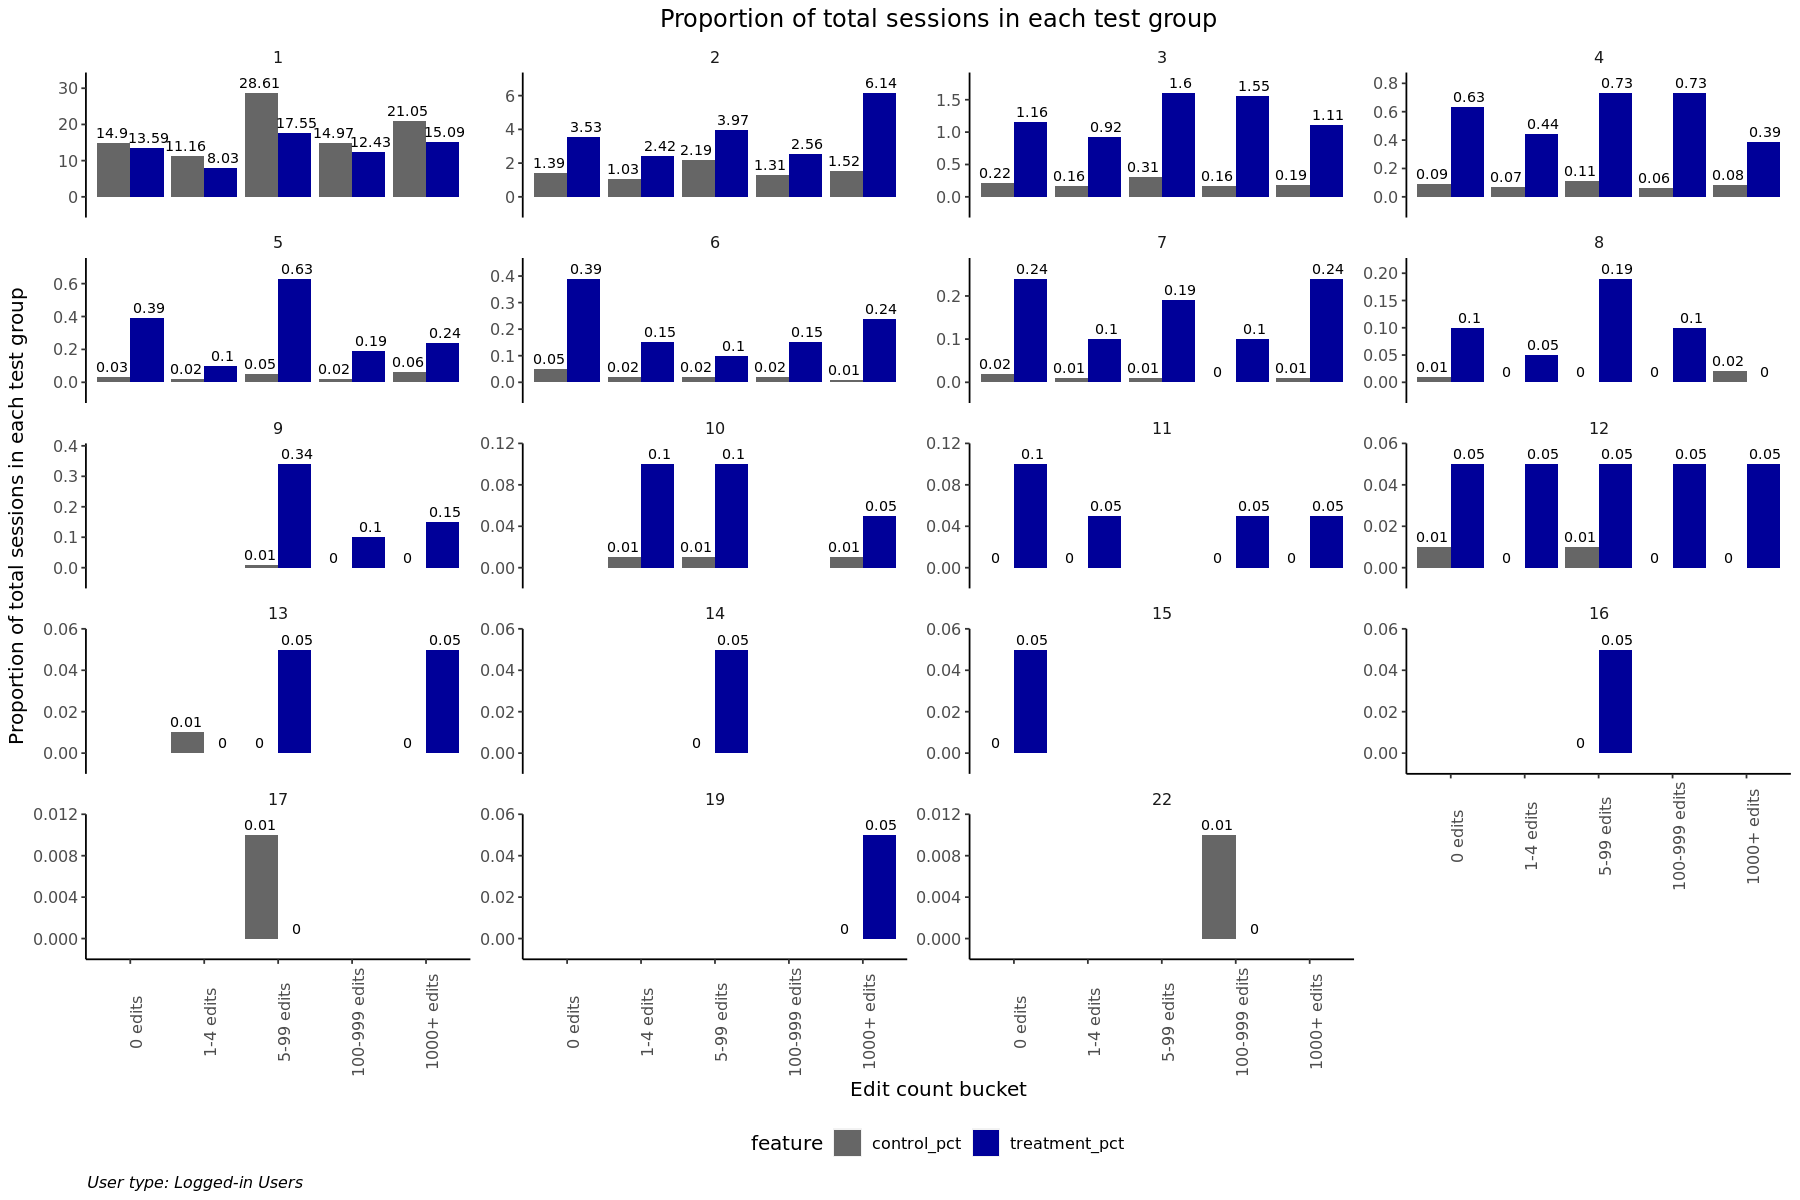

In [111]:
distribution_clicks_loggedin  <- df_his_L  %>%
        ggplot(aes(x =editcountbucket_lab , y= proportion, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +        
        geom_text(aes(label = paste(proportion)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~clicks , ncol=4, scale = 'free_y' ) +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.2)) +
        labs (
              y = "Proportion of total sessions in each test group" ,
             x = "Edit count bucket",
             title = "Proportion of total sessions in each test group" ,
             caption = "User type: Logged-in Users" ) +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
distribution_clicks_loggedin 

In [131]:


df_his_overall <- df_his %>%
  select(clicks, editcountbucket, control, treatment) %>%
  group_by(clicks) %>%
  summarize(total_clicks_control= sum(control), total_clicks_treatment= sum(treatment)) %>%
  mutate(
    control_pct = round(total_clicks_control*100/12746,2) ,
    treatment_pct = round(total_clicks_treatment*100/2068,2) 
 )

In [134]:
df_his_overall

clicks,total_clicks_control,total_clicks_treatment,control_pct,treatment_pct
<int>,<int>,<int>,<dbl>,<dbl>
1,11558,1379,90.68,66.68
2,948,385,7.44,18.62
3,134,131,1.05,6.33
4,53,60,0.42,2.90
5,22,32,0.17,1.55
6,13,21,0.10,1.02
7,5,18,0.04,0.87
8,4,9,0.03,0.44
9,1,12,0.01,0.58


In [135]:
df_his_login_overall_L <- df_his_overall %>% 
  filter(clicks<16) %>%
  gather("test_group","proportion",4:5) 


In [136]:
head(df_his_login_overall_L )

clicks,total_clicks_control,total_clicks_treatment,test_group,proportion
<int>,<int>,<int>,<chr>,<dbl>
1,11558,1379,control_pct,90.68
2,948,385,control_pct,7.44
3,134,131,control_pct,1.05
4,53,60,control_pct,0.42
5,22,32,control_pct,0.17
6,13,21,control_pct,0.10


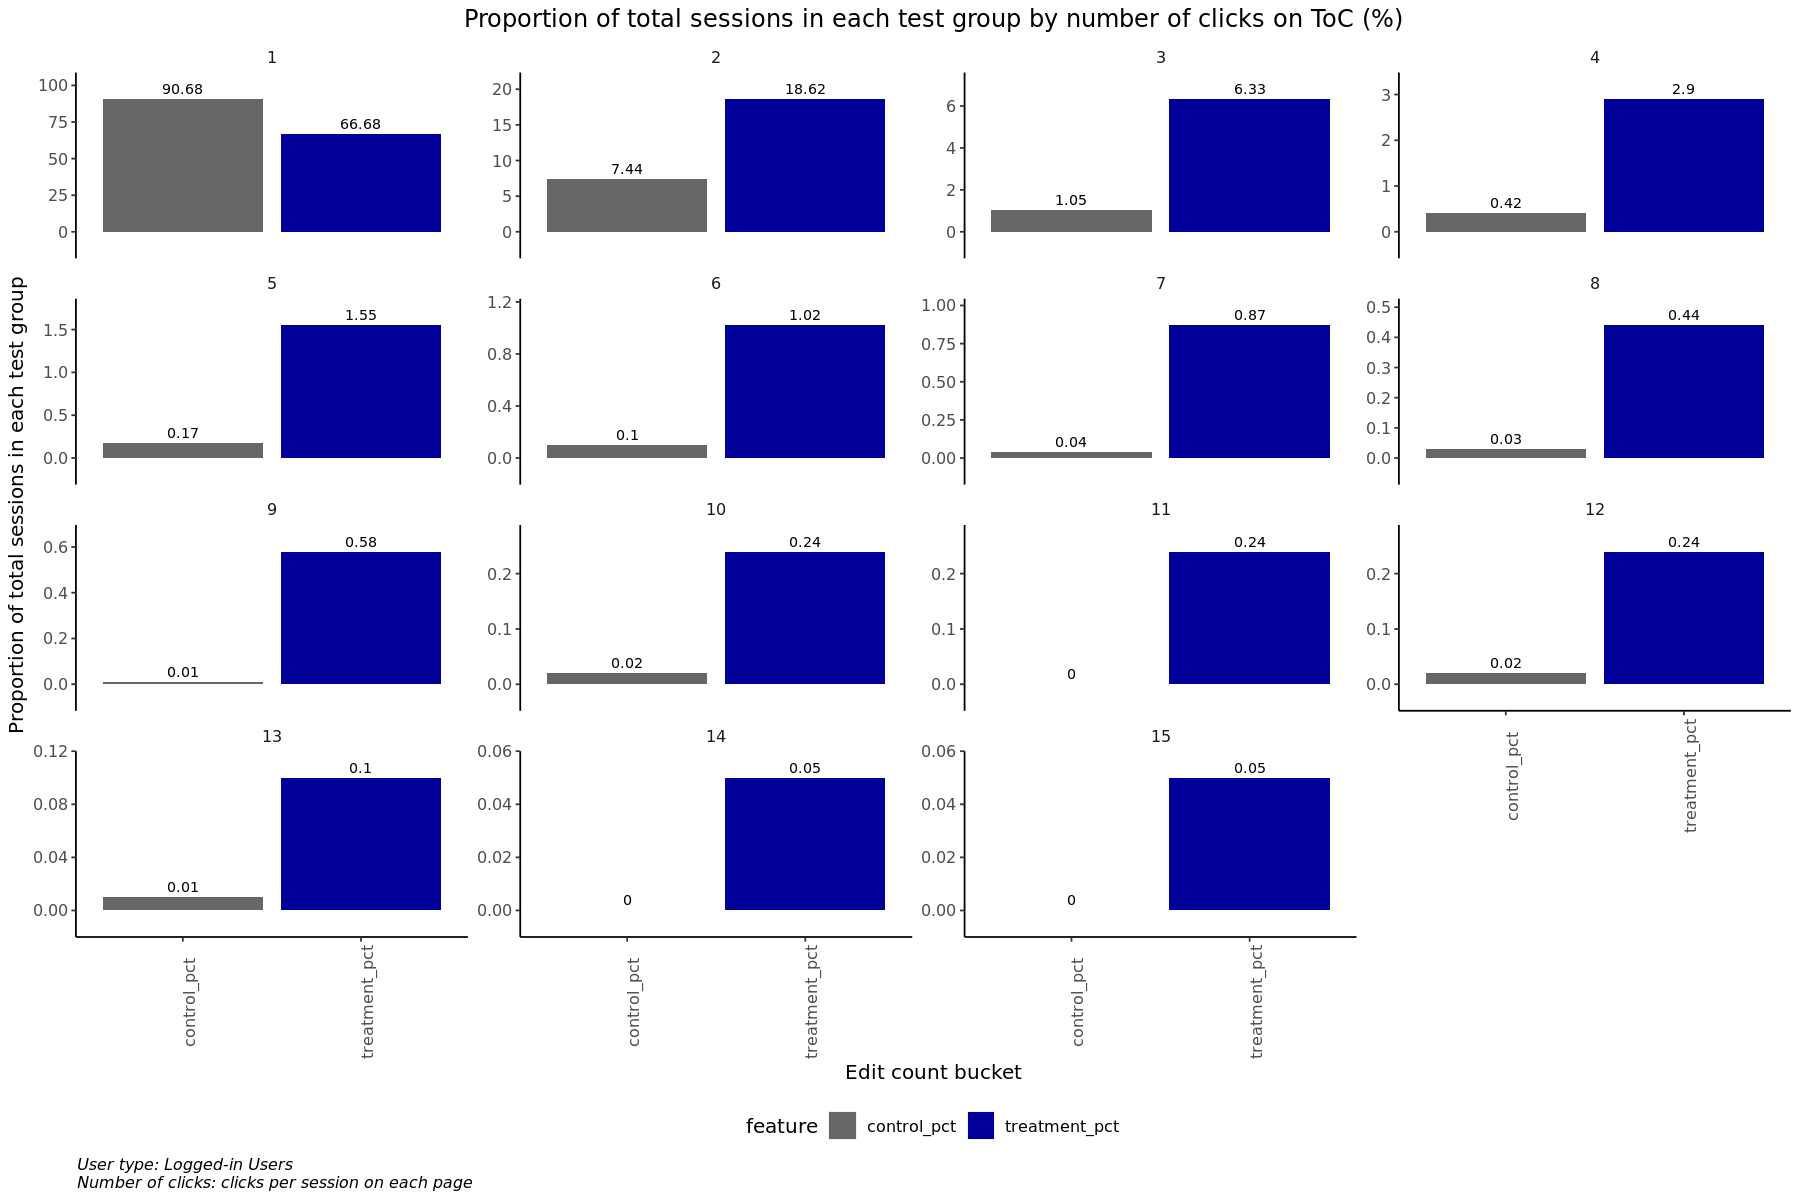

In [143]:
distribution_clicks_loggedin_overall  <- df_his_login_overall_L   %>%
        ggplot(aes(x =test_group , y= proportion, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +        
        geom_text(aes(label = paste(proportion)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~clicks , ncol=4, scale = 'free_y' ) +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.2)) +
        labs (
              y = "Proportion of total sessions in each test group" ,
             x = "Edit count bucket",
             title = "Proportion of total sessions in each test group by number of clicks on ToC (%)" ,
             caption = "User type: Logged-in Users    
Number of clicks: clicks per session on each page" ) +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
distribution_clicks_loggedin_overall

__Note__   

Control group has higher proportion of sessions has 1 click per page per session.  
Treatment group has higher propotion of session has MORE than 1 click per page per session.   
The trend is consistent among all eidt count buckets. 

### Modeling

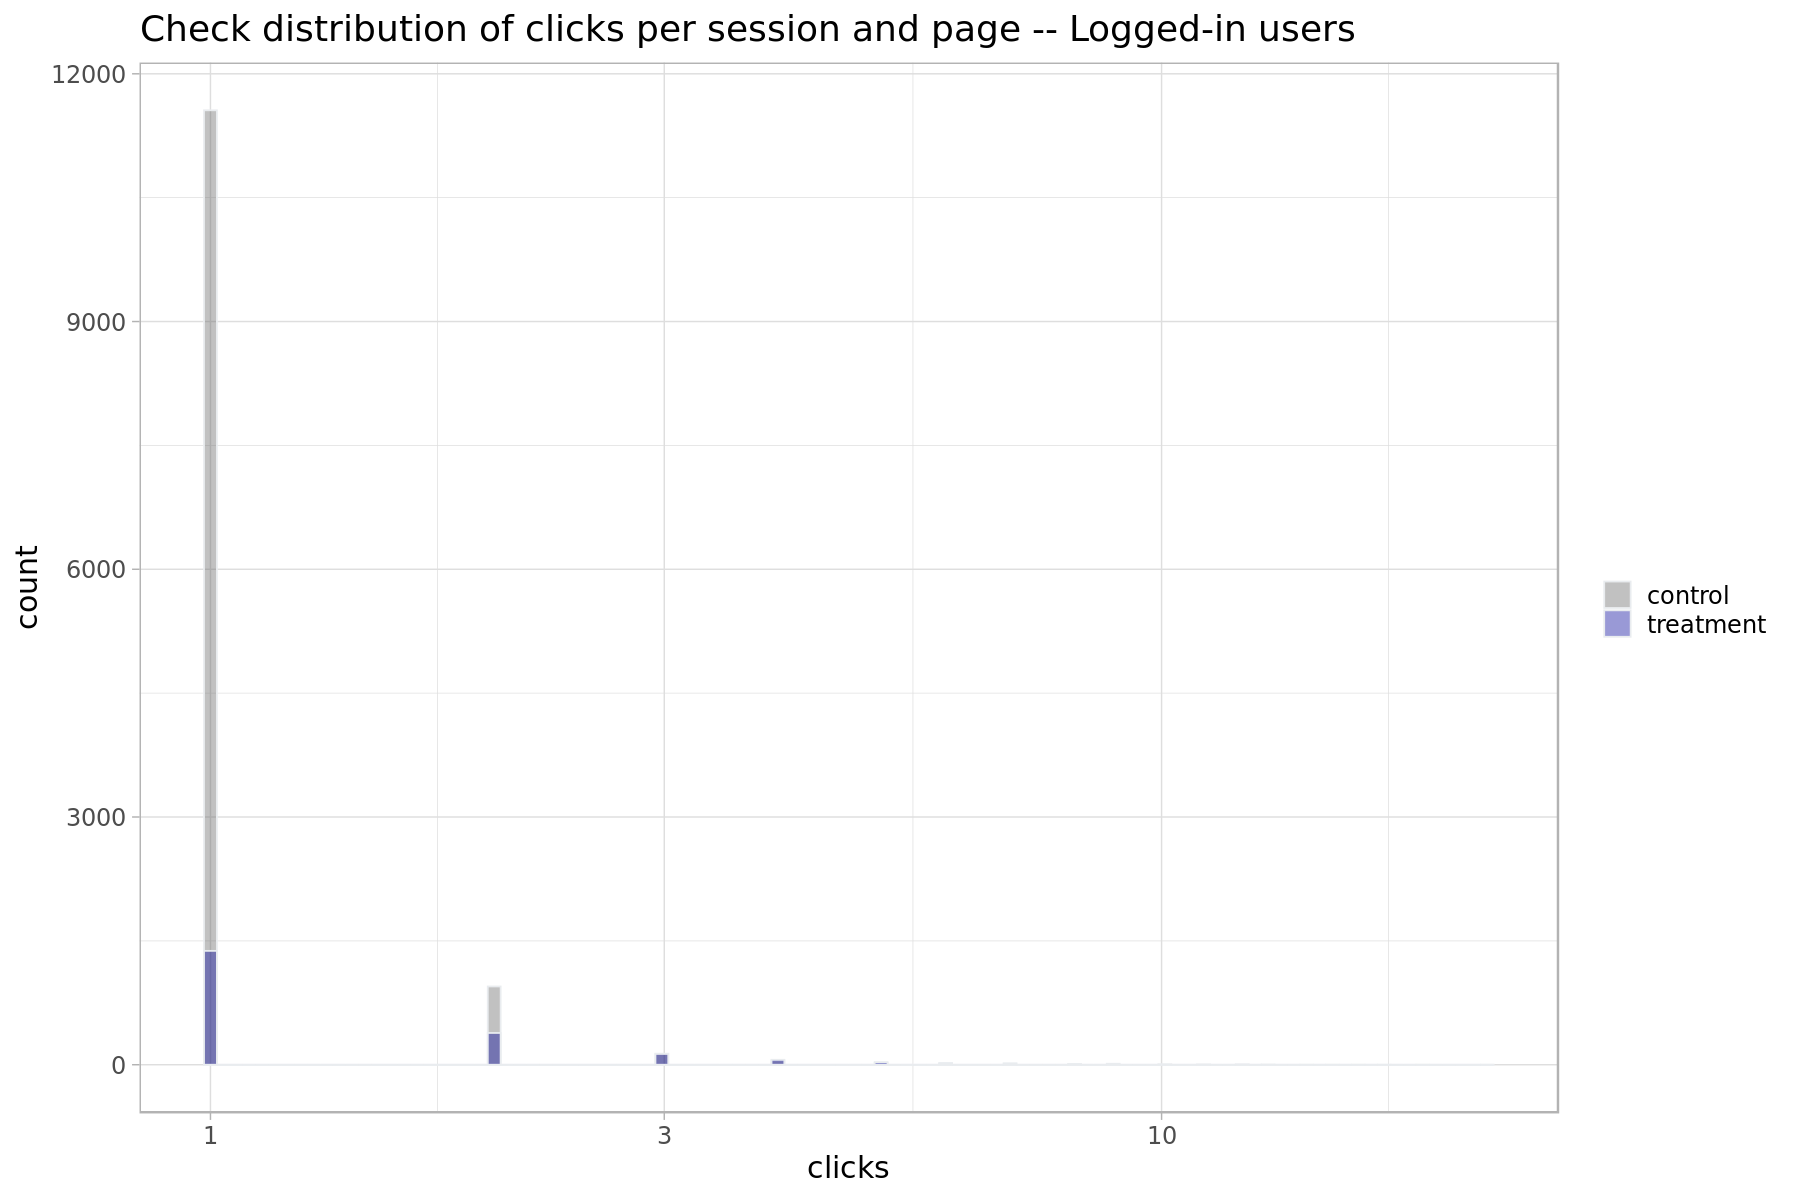

In [72]:
p1 <- df_loggedin %>%
 ggplot( aes(x=clicks, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of clicks per session and page -- Logged-in users",
         fill="") +
    theme_light(base_size=18)
p1

In [73]:
m1_c <- glmer( formula = clicks ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_loggedin)

In [74]:
summary(m1_c)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: clicks ~ test_group + (1 | wiki)
   Data: df_loggedin

     AIC      BIC   logLik deviance df.resid 
 35167.8  35190.6 -17580.9  35161.8    14811 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6590 -0.1305 -0.1058 -0.1058 19.8125 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.002401 0.049   
Number of obs: 14814, groups:  wiki, 19

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.16473    0.02024   8.141 3.93e-16 ***
test_grouptreatment  0.42831    0.01879  22.793  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.269

In [75]:
ranef(m1_c)

$wiki
                (Intercept)
bnwiki        -0.0139862494
dewikivoyage  -0.0165985605
euwiki         0.0299194990
fawiki         0.0362020390
frwiki        -0.0589616469
frwikiquote   -0.0016612509
frwiktionary   0.0015614160
hewiki        -0.0392206226
incubatorwiki  0.0281577045
kowiki         0.0545916918
plwikinews    -0.0008216889
ptwiki        -0.0342923244
ptwikinews     0.0147172497
ptwikiversity  0.0151654071
srwiki         0.0028571926
thwiki         0.0305091446
trwiki         0.0112486188
vecwiki       -0.0038529505
viwiki        -0.0524412853

with conditional variances for “wiki” 

In [76]:
anova(m1_c)
fixef(m1_c)

,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
test_group,1,521.3048,521.3048,521.3048


(Intercept) test_grouptreatment 
          0.1647251           0.4283142

In [77]:
exp(0.428314150565097)

[1] 1.534668

In [78]:
r.squaredGLMM(m1_c) 

Warning message:
“The null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.02835028,0.03143866
lognormal,0.03762507,0.04172381
trigamma,0.01957527,0.02170773


__Note:__  

__On logged-in users__: 

p-value < 2e-16. coefficient of test_grouptreatment is 0.42831 > 0. It means for the sessions with clicks on ToC, the treatment group has 53% more clicks on ToC than the control group. 

But only 4%(R2) of variance is explained by the model with fix variable test_group and random variable wiki. It means some other factors played role in influnce the number of clicks. One of possible factors is the length of pages. The longer pages possibly result in more clicks on ToC. However, We don't have page related info in data to confirm. 

## Anonymous user

In [112]:
df_anon <- df %>% 
  filter(isanon=='true')

In [114]:
head(df_anon)

,session_id,wiki,isanon,test_group,name,editcountbucket,pagetoken,clicks
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,00003645f652c5586de5,kowiki,true,treatment,ui.sidebar-toc,0 edits,888ed5c2cf536812553b,2
2,000054a3eb219587e6ed,viwiki,true,control,ui.toc,0 edits,e4aa818062fb8fa00749,1
3,00005658cad1c9bfdd9c,frwiki,true,control,ui.toc,0 edits,6574a7926c6a7559ed51,1
4,0000804a10182a407ca7,ptwiki,true,control,ui.toc,0 edits,5c701e60092b9dbade71,1
5,000082b0ad7fdaf4c466,frwiki,true,control,ui.toc,0 edits,71ebb420d6329e51005b,1
6,000099a312101de4df16,frwiki,true,control,ui.toc,0 edits,b948dcad9283239d243d,1


In [115]:
df_his_anon <- df_anon %>% 
  group_by(test_group, clicks) %>%
  summarize(cnt=n(), .groups='drop') %>%
  spread(test_group, cnt)

In [117]:
df_his_anon[is.na(df_his_anon)] <- 0

In [119]:
sum(df_his_anon[,'control'])

[1] 374636

In [120]:
sum(df_his_anon[,'treatment'])

[1] 62317

In [121]:
df_his_anon <- df_his_anon %>%
  mutate(
    control_pct = round(control*100/374636,2) ,
    treatment_pct = round(treatment*100/62317,2) 
 )

In [123]:
df_his_anon

clicks,control,treatment,control_pct,treatment_pct
<int>,<int>,<int>,<dbl>,<dbl>
1,336377,44575,89.79,71.53
2,29320,9651,7.83,15.49
3,5382,3477,1.44,5.58
4,1726,1687,0.46,2.71
5,710,898,0.19,1.44
6,402,614,0.11,0.99
7,195,379,0.05,0.61
8,137,276,0.04,0.44
9,99,177,0.03,0.28


In [126]:
df_his_anon_L <- df_his_anon %>%
   filter(clicks<16) %>%
   gather("test_group","proportion",4:5) 

In [127]:
head(df_his_anon_L)

clicks,control,treatment,test_group,proportion
<int>,<int>,<int>,<chr>,<dbl>
1,336377,44575,control_pct,89.79
2,29320,9651,control_pct,7.83
3,5382,3477,control_pct,1.44
4,1726,1687,control_pct,0.46
5,710,898,control_pct,0.19
6,402,614,control_pct,0.11


### Distribution of number of clicks

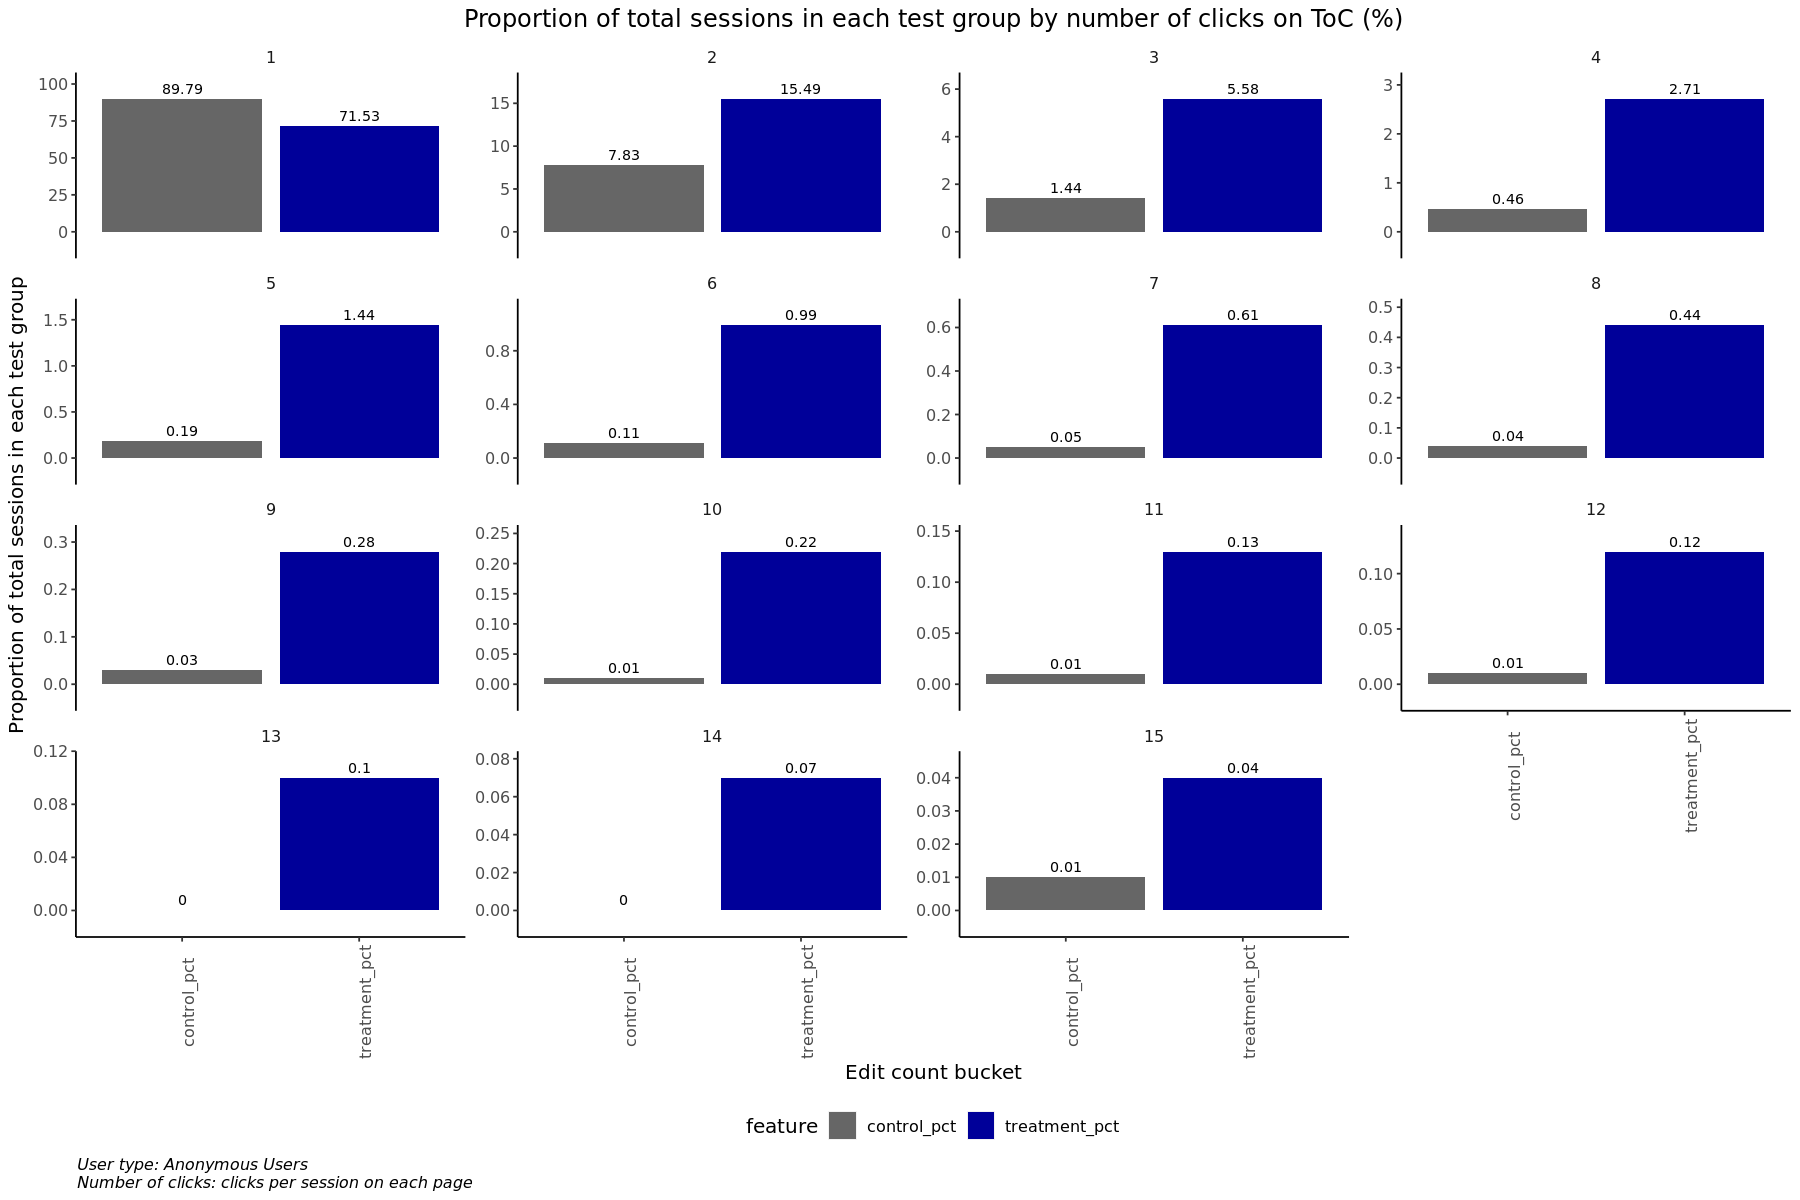

In [142]:
distribution_clicks_anon  <- df_his_anon_L  %>%
        ggplot(aes(x =test_group , y= proportion, fill=test_group)) +
        #make consistent width in geom_col for the category with missing data
        geom_col( position = position_dodge(preserve = "single") ) +        
        geom_text(aes(label = paste(proportion)), color = "black", position = position_dodge(width = 1), vjust = -0.5, hjust = 0.5, size = 3) +
        facet_wrap(~clicks , ncol=4, scale = 'free_y' ) +
        #make geom_text within the canvas's bounds
        scale_y_continuous(expand = expansion(mult = 0.2)) +
        labs (
              y = "Proportion of total sessions in each test group" ,
             x = "Edit count bucket",
             title = "Proportion of total sessions in each test group by number of clicks on ToC (%)" ,
             caption = "User type: Anonymous Users
Number of clicks: clicks per session on each page" ) +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
             #each plot's x axix lable
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
distribution_clicks_anon


### Modeling

In [144]:
m2_c <- glmer( formula = clicks ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_anon)

In [145]:
summary(m2_c)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: clicks ~ test_group + (1 | wiki)
   Data: df_anon

      AIC       BIC    logLik  deviance  df.resid 
1065983.9 1066016.8 -532988.9 1065977.9    436950 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -0.654  -0.173  -0.128  -0.128 179.572 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.002653 0.05151 
Number of obs: 436953, groups:  wiki, 20

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.19010    0.01363   13.95   <2e-16 ***
test_grouptreatment  0.36138    0.00346  104.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.056

In [146]:
fixef(m2_c)

(Intercept) test_grouptreatment 
          0.1901043           0.3613830

In [149]:
exp(0.361383038407578)

[1] 1.435313

In [150]:
r.squaredGLMM(m2_c) 

Warning message:
“The null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,0.02064321,0.02407310
lognormal,0.02748250,0.03204875
trigamma,0.01420581,0.01656612


__Note:__  

__On anonymous users__: 

p-value < 2e-16. coefficient of test_grouptreatment is 0.36138 > 0. It means for the sessions with clicks on ToC, the treatment group has 43.5% more clicks on ToC than the control group. 

But only 3%(R2) of variance is explained by the model with fixed variable test_group and random variable wiki. It means some other factors played a role in influencing the number of clicks. One of possible factors is the length of pages. The longer pages possibly result in more clicks on ToC. However, We don't have page related info in data to confirm.

__Summary__

Among the sessions with at least 1 click on ToC, the treatment group has more clicks on ToC than the control group. Data model predicts 53% more clicks on new ToC with logged-in users and 45.5% more clicks on new ToC with anonymous users.

Above estimated growth is only limited to the users who have clicked. We cannot confirm whether the new ToC has a higher adoption rate because we don't have correct data for users who see the new ToC with 0 click.
Above prediction is made based on an assumption that users' click behavior is not impacted by the previous ToC version they saw. 

The low R squared value indicates the model does not include all factors which influenced the number of clicks. One of possible factors is the length of pages. The longer pages possibly result in more clicks on ToC. However, We don't have page related info in data to confirm.